In [1]:
import os

import dill

import matplotlib.pyplot as plt
import torch
import pyro
import copy

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather
import seaborn as sns


import pyro
from pyro.infer import Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual

# from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
#from cities.modeling.zoning_models.distance_causal_model import DistanceCausalModel
from cities.modeling.zoning_models.tracts_model import TractsModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean

from cities.modeling.evaluation import (
    prep_data_for_test,
    test_performance,
)

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.interventional.handlers import do


smoke_test = "CI" in os.environ

# use when testing model health
smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:

census_tracts_data_path = os.path.join(root, "data/minneapolis/processed/census_tracts_dataset.pt")


ct_dataset_read = torch.load(census_tracts_data_path)

ct_loader = DataLoader(
    ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True
)

data = next(iter(ct_loader))

print(data["continuous"].keys())
print(data['categorical'].keys())   


dict_keys(['housing_units', 'housing_units_original', 'total_value', 'total_value_original', 'median_value', 'median_value_original', 'mean_limit', 'median_distance', 'median_distance_original', 'mean_distance', 'mean_distance_original'])
dict_keys(['year'])


In [3]:
kwargs = {
    "categorical": [
        "year",
    ],
    "continuous": {
      'housing_units',
      'total_value',
      'median_value',
      'mean_limit',
      'median_distance'
    },
    'outcome': 'housing_units'
}

subset = select_from_data(data, kwargs)
print(subset["continuous"].keys())


dict_keys(['housing_units', 'total_value', 'median_value', 'mean_limit', 'median_distance'])


In [4]:
tracts_model = TractsModel(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)

print(tr.trace.nodes.keys())

odict_keys(['data', 'year', 'distance', 'sigma_limit', 'bias_continuous_distance_limit', 'weight_continuous_distance_limit_', 'weights_categorical_year_limit', 'mean_outcome_prediction_limit', 'limit', 'sigma_total_value', 'bias_continuous_distance_total_value', 'weight_continuous_distance_total_value_', 'bias_continuous_limit_total_value', 'weight_continuous_limit_total_value_', 'weights_categorical_year_total_value', 'mean_outcome_prediction_total_value', 'total_value', 'sigma_median_value', 'bias_continuous_distance_median_value', 'weight_continuous_distance_median_value_', 'bias_continuous_limit_median_value', 'weight_continuous_limit_median_value_', 'weights_categorical_year_median_value', 'mean_outcome_prediction_median_value', 'median_value', 'sigma_housing_units', 'bias_continuous_total_value_housing_units', 'weight_continuous_total_value_housing_units_', 'bias_continuous_median_value_housing_units', 'weight_continuous_median_value_housing_units_', 'bias_continuous_distance_hou

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


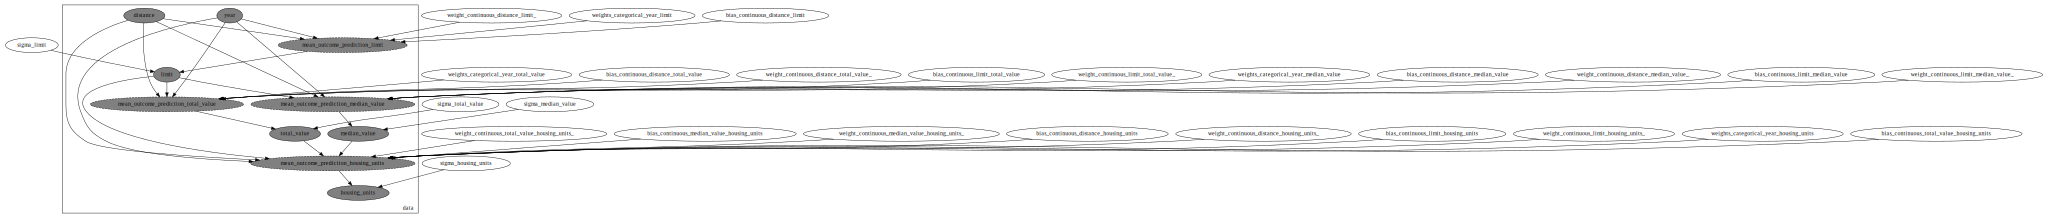

In [5]:
pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

[iteration 0001] loss: 4752.3018
[iteration 0050] loss: 4328.5562
[iteration 0100] loss: 4135.0811
[iteration 0150] loss: 4062.0767
[iteration 0200] loss: 4041.6138
[iteration 0250] loss: 4035.2510
[iteration 0300] loss: 4026.1814
[iteration 0350] loss: 4020.1499
[iteration 0400] loss: 4040.9128
[iteration 0450] loss: 4026.5310
[iteration 0500] loss: 4028.7891
[iteration 0550] loss: 4023.1826
[iteration 0600] loss: 4029.6162
[iteration 0650] loss: 4026.1013
[iteration 0700] loss: 4015.9226
[iteration 0750] loss: 4020.9275
[iteration 0800] loss: 4028.1631
[iteration 0850] loss: 4018.3257
[iteration 0900] loss: 4017.8799
[iteration 0950] loss: 4053.1106
[iteration 1000] loss: 4030.0415
[iteration 1050] loss: 4026.4460
[iteration 1100] loss: 4032.1636
[iteration 1150] loss: 4030.5945
[iteration 1200] loss: 4024.5261
[iteration 1250] loss: 4020.7712
[iteration 1300] loss: 4021.2222
[iteration 1350] loss: 4023.2932
[iteration 1400] loss: 4027.0046
[iteration 1450] loss: 4020.8787
[iteration

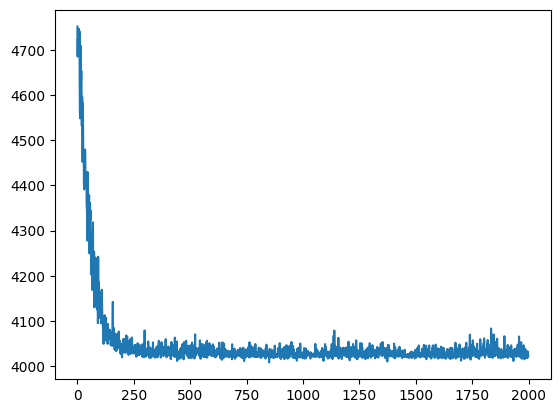

tensor(0.3065) tensor(0.2383)


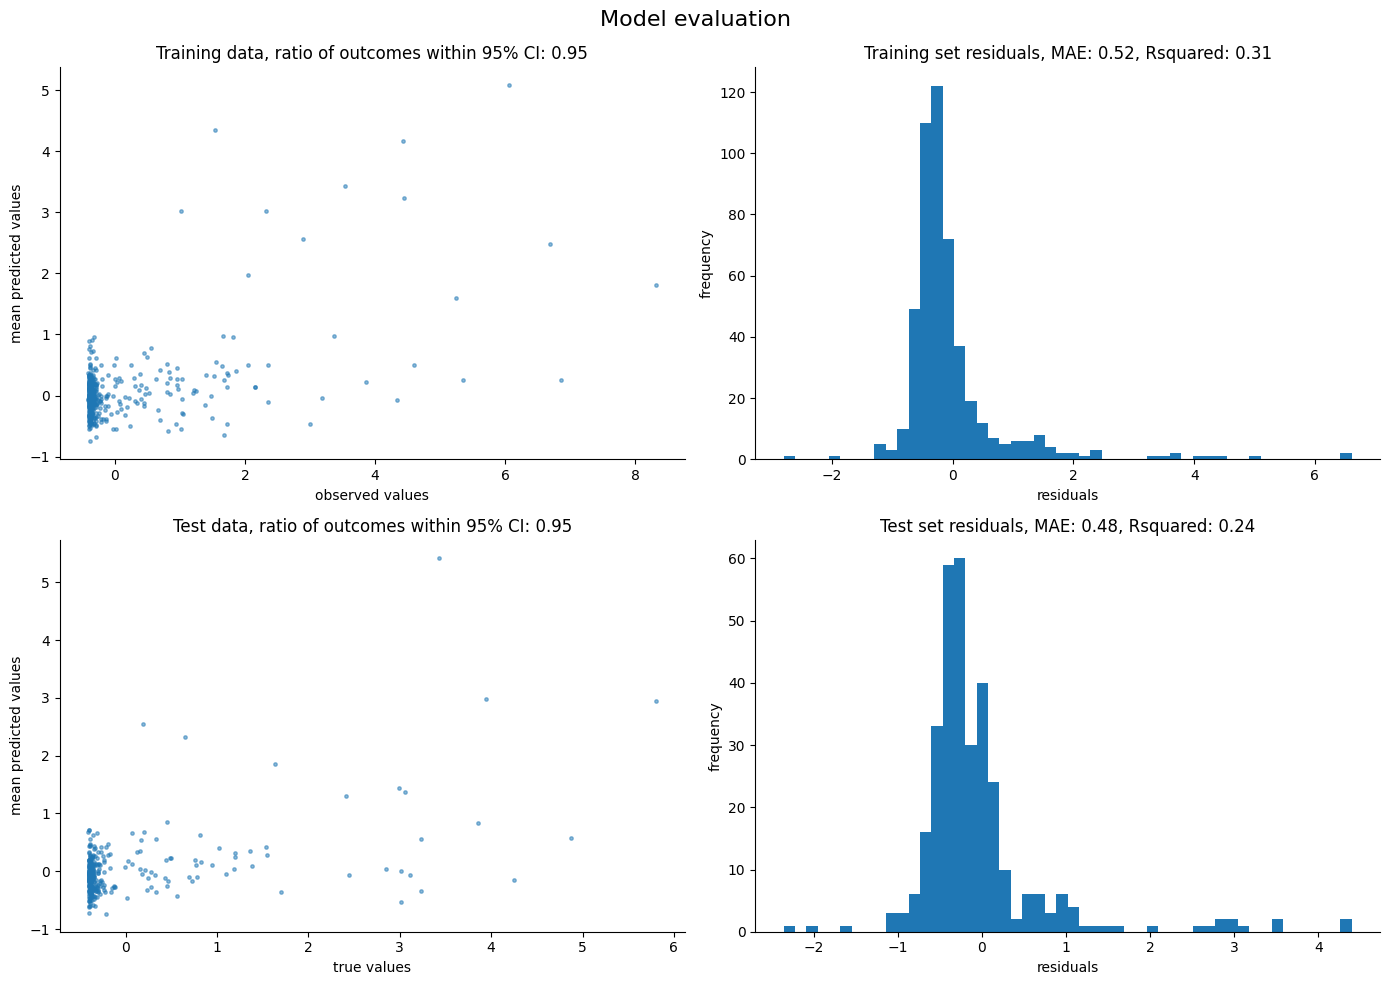

{'mae_train': 0.520340621471405,
 'mae_test': 0.4826427102088928,
 'rsquared_train': tensor(0.3065),
 'rsquared_test': tensor(0.2383),
 'coverage_train': 0.9515151381492615,
 'coverage_test': 0.9484848380088806}

In [6]:
pyro.clear_param_store()
from cities.modeling.evaluation import recode_categorical
import copy

train_loader, test_loader, categorical_levels = prep_data_for_test(
    census_tracts_data_path,
    train_size=0.6)



test_performance(
    tracts_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    outcome_type="continuous",
    outcome_name="housing_units",
    n_steps=2000,
    plot=True,
    is_class=False,
)


[iteration 0001] loss: 7756.6392
[iteration 0050] loss: 6685.7964
[iteration 0100] loss: 6500.0679
[iteration 0150] loss: 6517.3838
[iteration 0200] loss: 6496.0488
[iteration 0250] loss: 6495.4517
[iteration 0300] loss: 6491.7603
[iteration 0350] loss: 6569.0605
[iteration 0400] loss: 6476.7837
[iteration 0450] loss: 6501.9165
[iteration 0500] loss: 6495.7769
[iteration 0550] loss: 6496.1914
[iteration 0600] loss: 6521.6045
[iteration 0650] loss: 6496.1719
[iteration 0700] loss: 6479.8857
[iteration 0750] loss: 6498.9814
[iteration 0800] loss: 6485.8999
[iteration 0850] loss: 6488.2275
[iteration 0900] loss: 6520.0068
[iteration 0950] loss: 6508.0215
[iteration 1000] loss: 6512.5107
[iteration 1050] loss: 6485.2183
[iteration 1100] loss: 6515.0332
[iteration 1150] loss: 6498.1870
[iteration 1200] loss: 6547.8267
[iteration 1250] loss: 6509.4937
[iteration 1300] loss: 6489.3125
[iteration 1350] loss: 6487.7773
[iteration 1400] loss: 6487.1172
[iteration 1450] loss: 6494.1807
[iteration

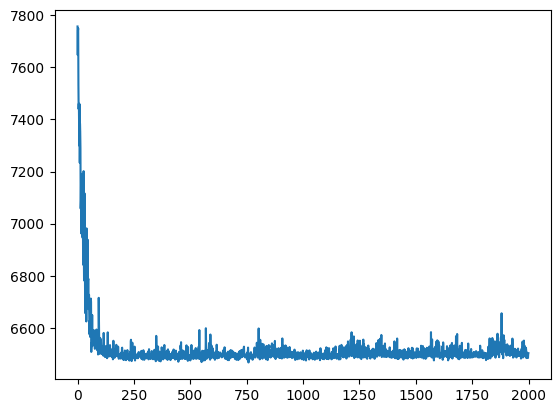

In [7]:
pyro.clear_param_store()
guide = run_svi_inference(
    tracts_model, n_steps=2000, lr=0.03, **subset
)

predictive = Predictive(tracts_model, guide=guide, num_samples=1000)

subset_for_preds = copy.deepcopy(subset)
subset_for_preds['continuous']['housing_units'] = None  

preds = predictive(**subset_for_preds)

dict_keys(['sigma_limit', 'bias_continuous_distance_limit', 'weight_continuous_distance_limit_', 'weights_categorical_year_limit', 'sigma_total_value', 'bias_continuous_distance_total_value', 'weight_continuous_distance_total_value_', 'bias_continuous_limit_total_value', 'weight_continuous_limit_total_value_', 'weights_categorical_year_total_value', 'sigma_median_value', 'bias_continuous_distance_median_value', 'weight_continuous_distance_median_value_', 'bias_continuous_limit_median_value', 'weight_continuous_limit_median_value_', 'weights_categorical_year_median_value', 'sigma_housing_units', 'bias_continuous_total_value_housing_units', 'weight_continuous_total_value_housing_units_', 'bias_continuous_median_value_housing_units', 'weight_continuous_median_value_housing_units_', 'bias_continuous_distance_housing_units', 'weight_continuous_distance_housing_units_', 'bias_continuous_limit_housing_units', 'weight_continuous_limit_housing_units_', 'weights_categorical_year_housing_units', 

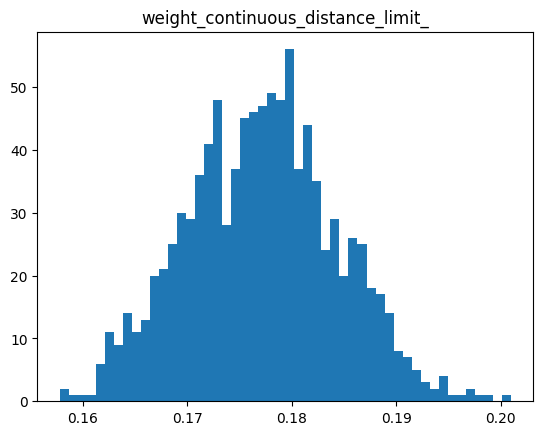

weights_categorical_year_limit
weights_categorical_year_limit tensor([[ 0.4867,  0.4515, -0.0770, -0.0962,  0.4945,  0.4605, -0.0881, -0.0927,
         -0.0861, -0.1129]])


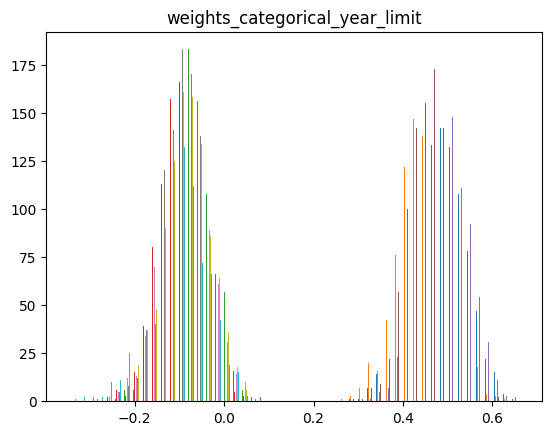

weight_continuous_distance_total_value_
weight_continuous_distance_total_value_ tensor([0.2838])


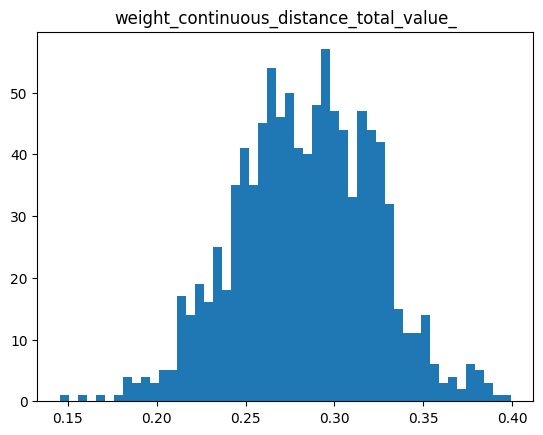

weight_continuous_limit_total_value_
weight_continuous_limit_total_value_ tensor([-0.9957])


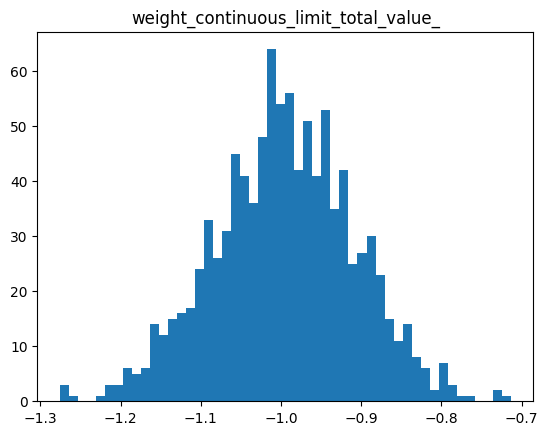

weights_categorical_year_total_value
weights_categorical_year_total_value tensor([[ 1.2302e-01,  2.0008e-01, -3.2246e-05,  5.7707e-02,  1.1755e-01,
          2.1182e-01, -2.0230e-01, -2.1272e-01, -9.8440e-02, -8.1363e-02]])


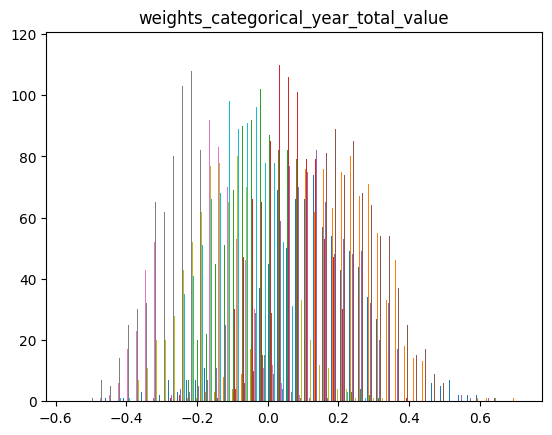

weight_continuous_distance_median_value_
weight_continuous_distance_median_value_ tensor([0.1293])


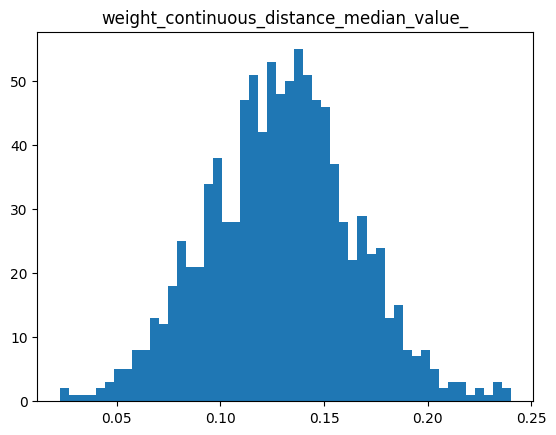

weight_continuous_limit_median_value_
weight_continuous_limit_median_value_ tensor([0.1639])


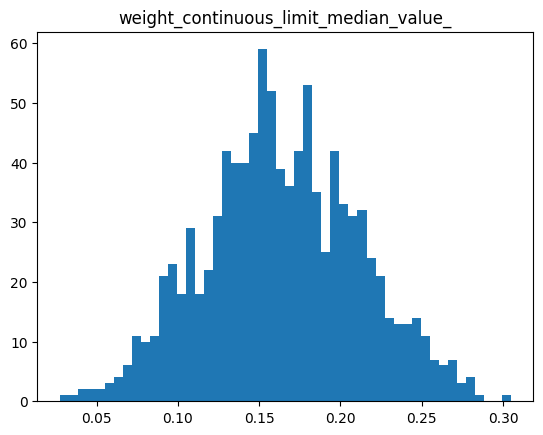

weights_categorical_year_median_value
weights_categorical_year_median_value tensor([[-3.1173e-01, -4.4613e-01,  3.3946e-01,  4.0165e-01, -3.6696e-01,
         -3.6161e-01, -6.0316e-02,  4.2844e-04,  1.1206e-01,  6.3278e-01]])


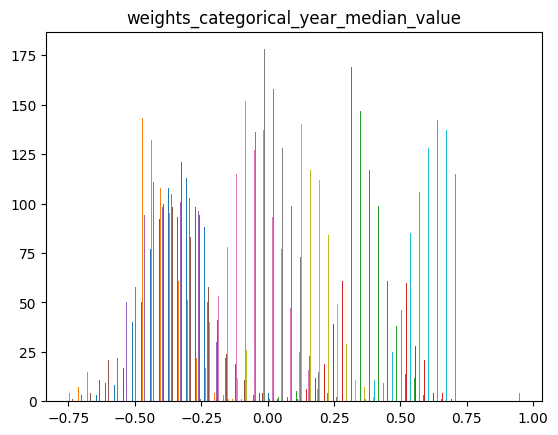

weight_continuous_total_value_housing_units_
weight_continuous_total_value_housing_units_ tensor([0.4738])


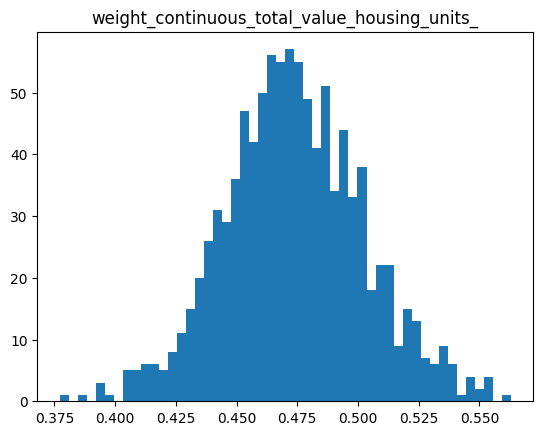

weight_continuous_median_value_housing_units_
weight_continuous_median_value_housing_units_ tensor([-0.1717])


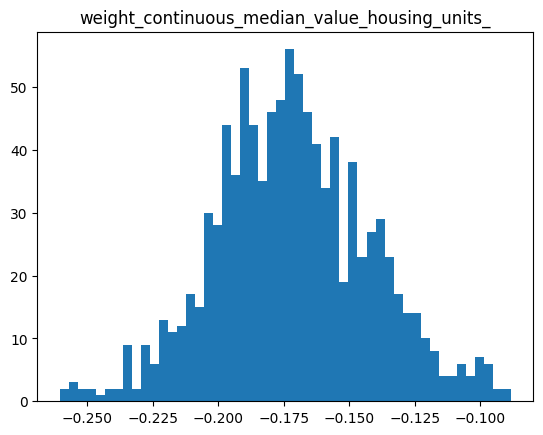

weight_continuous_distance_housing_units_
weight_continuous_distance_housing_units_ tensor([0.1225])


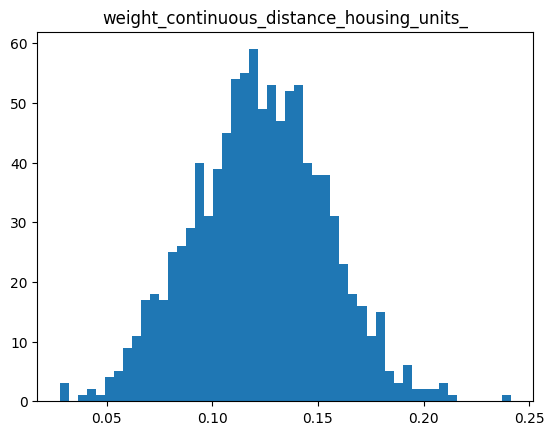

weight_continuous_limit_housing_units_
weight_continuous_limit_housing_units_ tensor([-0.7514])


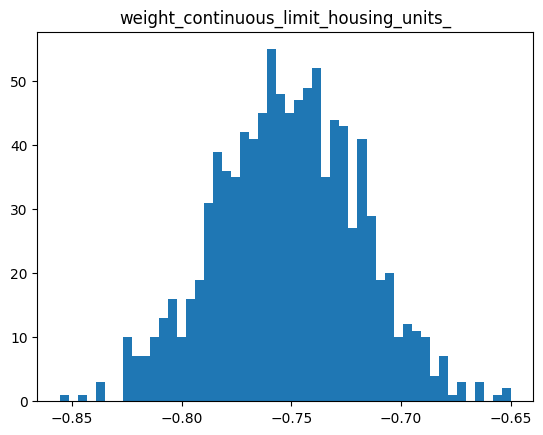

weights_categorical_year_housing_units
weights_categorical_year_housing_units tensor([[ 0.0921,  0.2310, -0.2410, -0.0111,  0.4864,  0.1957, -0.2380, -0.1247,
         -0.1225, -0.0781]])


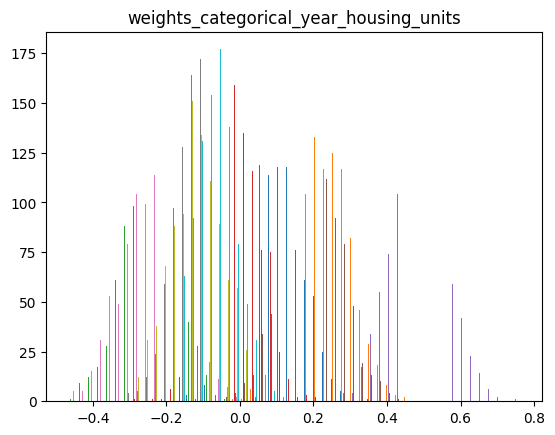

In [8]:
print(preds.keys())

for key in preds.keys():
   
    if key.startswith("weight"):
        print(key)
        print(key, preds[key].mean(axis = 0))
        plt.hist(preds[key].squeeze().detach().numpy(), bins=50)
        plt.title(key)
        plt.show()